# Detect disturbed tress

## Packages and Data

In [158]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [159]:
import pandas as pd
import numpy as np
from utils.constants import spectral_bands, indices
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from scipy.stats import pointbiserialr
from utils.preprocessing import Preprocessing
from scipy.stats import linregress

In [160]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/Trainings_Datensatz.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

df = Preprocessing.interpolate_b4(df, method="linear")

In [161]:
calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

## Calculate std deviation for every index column
1. Normalize columns so that those with higher ranges do not have a greater influence
2. Group by year and compute the mean of each index column
3. Compute the standard deviation of the yearly values
4. Join column "is_disturbed" to the resulting df

In [162]:
bands_and_indices = spectral_bands + indices

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[bands_and_indices] = df.groupby("species")[bands_and_indices].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
) 
# normalization grouped by species because different species can have different ranges 

In [163]:
df_yearly = df_norm.groupby(["id", "year"])[bands_and_indices].mean().reset_index()
std_df = df_yearly.groupby("id")[bands_and_indices].std().reset_index()
std_df = std_df.rename(columns={col: f"{col}_stdv" for col in bands_and_indices})

df_disturbance = df.groupby("id")["is_disturbed"].first().reset_index()
std_df = std_df.merge(df_disturbance, on="id", how="left")

In [164]:
std_df

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,b12_stdv,ndvi_stdv,gndvi_stdv,wdvi_stdv,tndvi_stdv,savi_stdv,ipvi_stdv,mcari_stdv,reip_stdv,masvi2_stdv,dvi_stdv,is_disturbed
0,1,0.001443,0.002388,0.002022,0.002207,0.006962,0.008983,0.008581,0.008661,0.002837,0.001783,0.005050,0.004492,0.008265,0.003255,0.005164,0.005050,0.000174,0.000159,0.000059,0.007326,False
1,2,0.002638,0.004479,0.003646,0.004730,0.005678,0.007194,0.005216,0.007551,0.009846,0.004505,0.012423,0.011259,0.006677,0.010242,0.012420,0.012423,0.000398,0.000155,0.002494,0.005223,False
2,3,0.005808,0.007473,0.011374,0.013846,0.022905,0.024976,0.027478,0.027717,0.030973,0.020295,0.055209,0.029003,0.044712,0.041316,0.055254,0.055209,0.002571,0.000085,0.000064,0.048469,True
3,4,0.003046,0.007629,0.008592,0.011366,0.018492,0.020920,0.023722,0.021066,0.015042,0.006908,0.018311,0.009050,0.028927,0.014787,0.018295,0.018311,0.000663,0.000142,0.009052,0.018591,False
4,5,0.002885,0.004692,0.006805,0.007227,0.017081,0.017616,0.018928,0.017664,0.008911,0.009031,0.030002,0.019241,0.033850,0.023179,0.030034,0.030002,0.002147,0.000067,0.000033,0.039482,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28207,28208,0.002490,0.003957,0.005900,0.007598,0.009079,0.008313,0.008750,0.010352,0.010685,0.006356,0.025927,0.016005,0.015582,0.021057,0.025953,0.025927,0.001103,0.000076,0.000054,0.019025,False
28208,28209,0.007227,0.008205,0.013705,0.016075,0.012198,0.015518,0.014618,0.015827,0.043116,0.028573,0.089233,0.068358,0.026903,0.064027,0.089236,0.089233,0.001054,0.000701,0.006053,0.034537,True
28209,28210,0.001678,0.001161,0.003130,0.001578,0.004340,0.006149,0.006252,0.006839,0.005941,0.003787,0.014378,0.007609,0.011202,0.010657,0.014393,0.014378,0.000768,0.000047,0.000012,0.013326,False
28210,28211,0.002685,0.002356,0.004028,0.002783,0.006951,0.010522,0.009819,0.008603,0.012807,0.012444,0.030090,0.028686,0.014378,0.019028,0.030101,0.030090,0.001399,0.000487,0.001300,0.019665,False


## Calculate slope of yearly mean

In [167]:
slope_list_all = None

for col in bands_and_indices:
    slopes_per_feature = []
    for id_ in df_yearly["id"].unique():
        df_sub = df_yearly[df_yearly["id"] == id_]
        if len(df_sub) >= 2:  # Regression braucht mindestens 2 Punkte
            slope, intercept, r_value, p_value, std_err = linregress(df_sub["year"], df_sub[col])
        else:
            slope = 0
        slopes_per_feature.append({"id": id_, f"{col}_slope": slope})
    
    slope_df = pd.DataFrame(slopes_per_feature)
    if slope_list_all is None:
        slope_list_all = slope_df
    else:
        slope_list_all = slope_list_all.merge(slope_df, on="id")


In [168]:
std_slope_df = std_df.merge(slope_list_all, on="id", how="left")

std_slope_df

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,b12_stdv,ndvi_stdv,gndvi_stdv,wdvi_stdv,tndvi_stdv,savi_stdv,ipvi_stdv,mcari_stdv,reip_stdv,masvi2_stdv,dvi_stdv,is_disturbed,b2_slope,b3_slope,b4_slope,b5_slope,b6_slope,b7_slope,b8_slope,b8a_slope,b11_slope,b12_slope,ndvi_slope,gndvi_slope,wdvi_slope,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope
0,1,0.001443,0.002388,0.002022,0.002207,0.006962,0.008983,0.008581,0.008661,0.002837,0.001783,0.005050,0.004492,0.008265,0.003255,0.005164,0.005050,0.000174,0.000159,0.000059,0.007326,False,-0.000366,-0.000571,-0.000502,-0.000601,-0.002409,-0.003121,-0.002611,-0.002757,0.000664,0.000503,-0.001657,-0.002188,-0.002544,-0.001054,-0.001696,-0.001657,-0.000034,-0.000039,0.000023,-0.002282
1,2,0.002638,0.004479,0.003646,0.004730,0.005678,0.007194,0.005216,0.007551,0.009846,0.004505,0.012423,0.011259,0.006677,0.010242,0.012420,0.012423,0.000398,0.000155,0.002494,0.005223,False,-0.000173,0.000100,0.000073,0.000703,0.001233,0.001430,0.002007,0.002601,0.003600,0.001550,0.001441,0.001070,0.002870,0.001258,0.001442,0.001441,-0.000080,-0.000013,-0.000806,0.002240
2,3,0.005808,0.007473,0.011374,0.013846,0.022905,0.024976,0.027478,0.027717,0.030973,0.020295,0.055209,0.029003,0.044712,0.041316,0.055254,0.055209,0.002571,0.000085,0.000064,0.048469,True,0.001813,0.002815,0.002534,0.005399,0.010261,0.010875,0.012158,0.012254,0.011850,0.007430,-0.008487,-0.005496,0.018602,-0.006870,-0.008487,-0.008487,0.000960,-0.000025,-0.000030,0.018101
3,4,0.003046,0.007629,0.008592,0.011366,0.018492,0.020920,0.023722,0.021066,0.015042,0.006908,0.018311,0.009050,0.028927,0.014787,0.018295,0.018311,0.000663,0.000142,0.009052,0.018591,False,0.000951,0.003184,0.003617,0.005218,0.008760,0.009572,0.010809,0.009119,0.007912,0.003558,-0.007450,-0.002596,0.013322,-0.005928,-0.007442,-0.007450,-0.000057,-0.000015,-0.004100,0.008674
4,5,0.002885,0.004692,0.006805,0.007227,0.017081,0.017616,0.018928,0.017664,0.008911,0.009031,0.030002,0.019241,0.033850,0.023179,0.030034,0.030002,0.002147,0.000067,0.000033,0.039482,False,0.000211,-0.000949,0.000385,-0.001559,-0.005534,-0.005065,-0.006065,-0.005501,0.001595,0.002399,-0.005623,-0.000448,-0.010529,-0.003660,-0.005630,-0.005623,-0.001078,0.000020,0.000006,-0.011740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28207,28208,0.002490,0.003957,0.005900,0.007598,0.009079,0.008313,0.008750,0.010352,0.010685,0.006356,0.025927,0.016005,0.015582,0.021057,0.025953,0.025927,0.001103,0.000076,0.000054,0.019025,False,0.000841,0.001771,0.002043,0.003844,0.003727,0.002551,0.002509,0.004152,0.004868,0.001523,0.003013,0.000160,0.002687,0.003052,0.003016,0.003013,0.000259,-0.000030,-0.000021,0.001236
28208,28209,0.007227,0.008205,0.013705,0.016075,0.012198,0.015518,0.014618,0.015827,0.043116,0.028573,0.089233,0.068358,0.026903,0.064027,0.089236,0.089233,0.001054,0.000701,0.006053,0.034537,True,0.003331,0.003739,0.006615,0.007545,-0.001087,-0.003867,-0.003338,-0.002648,0.020991,0.013925,-0.044729,-0.033656,-0.010395,-0.032090,-0.044730,-0.044729,-0.000508,-0.000339,0.002036,-0.015900
28209,28210,0.001678,0.001161,0.003130,0.001578,0.004340,0.006149,0.006252,0.006839,0.005941,0.003787,0.014378,0.007609,0.011202,0.010657,0.014393,0.014378,0.000768,0.000047,0.000012,0.013326,False,0.000175,-0.000138,0.000250,-0.000213,-0.001047,-0.001374,-0.000092,-0.001181,-0.000322,-0.000091,-0.001693,-0.001259,-0.000345,-0.001347,-0.001695,-0.001693,-0.000104,0.000002,0.000001,-0.000579
28210,28211,0.002685,0.002356,0.004028,0.002783,0.006951,0.010522,0.009819,0.008603,0.012807,0.012444,0.030090,0.028686,0.014378,0.019028,0.030101,0.030090,0.001399,0.000487,0.001300,0.019665,False,0.000543,0.000446,0.000952,0.000556,-0.001664,-0.003125,-0.002843,-0.002158,0.004986,0.004734,-0.008685,-0.008949,-0.004193,-0.005434,-0.008688,-0.008685,-0

## Correlation between features and disturbance

In [171]:
correlations = []

for col in [c for c in std_slope_df.columns if c.endswith("_stdv") or c.endswith("_slope")]:
    r, p = pointbiserialr(std_slope_df["is_disturbed"].astype(int), std_slope_df[col])
    correlations.append({"feature": col, "correlation": r, "p_value": p})

correlations = pd.DataFrame(correlations).sort_values(by="correlation", ascending=False)

correlations

,feature,correlation,p_value
28,b11_slope,0.531285,0.000000e+00
23,b5_slope,0.528492,0.000000e+00
8,b11_stdv,0.517996,0.000000e+00
11,gndvi_stdv,0.514982,0.000000e+00
3,b5_stdv,0.501880,0.000000e+00
20,b2_slope,0.492893,0.000000e+00
15,ipvi_stdv,0.487777,0.000000e+00
10,ndvi_stdv,0.487777,0.000000e+00
14,savi_stdv,0.486328,0.000000e+00
21,b3_slope,0.467523,0.000000e+00


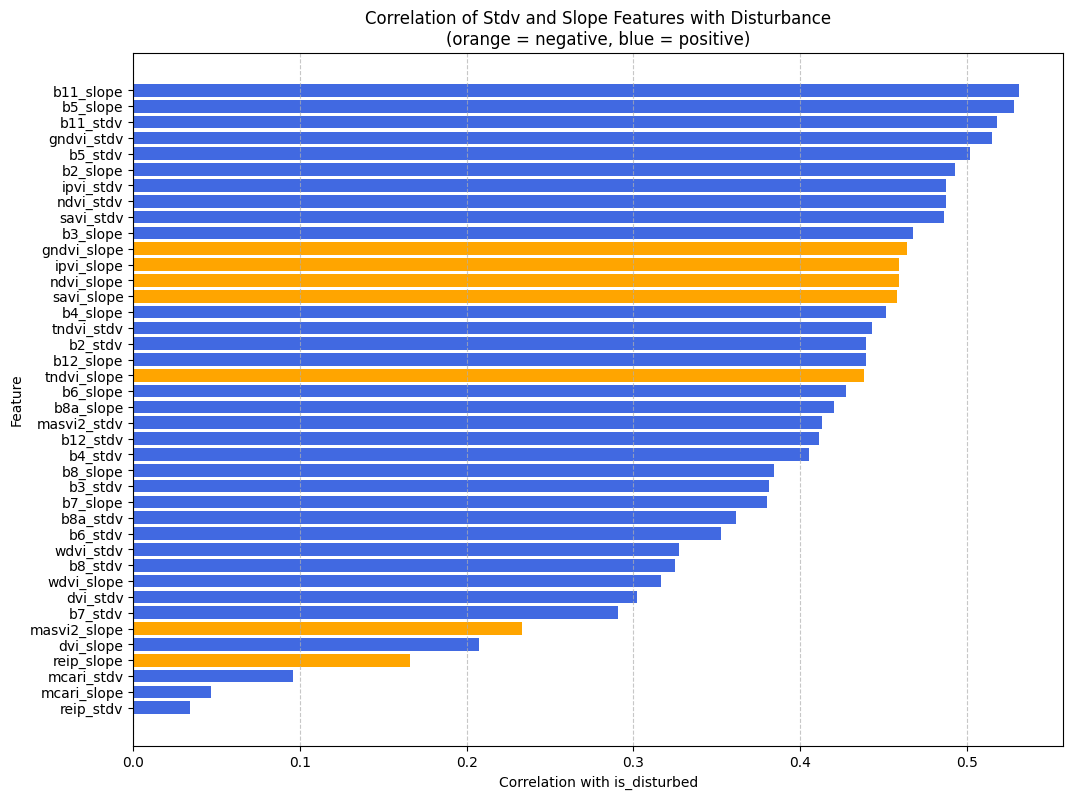

In [179]:
correlations["abs_corr"] = correlations["correlation"].abs()

correlations_df_to_plot = correlations.sort_values(by="abs_corr", ascending=True)
colors = ["orange" if val < 0 else "royalblue" for val in correlations_df_to_plot["correlation"]]

plt.figure(figsize=(12, 9))
plt.barh(
    correlations_df_to_plot["feature"],
    correlations_df_to_plot["abs_corr"],
    color=colors
)

plt.xlabel("Correlation with is_disturbed")
plt.ylabel("Feature")
plt.title("Correlation of Stdv and Slope Features with Disturbance\n(orange = negative, blue = positive)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

## Analysis stdv of indices 

In [221]:
col = "b11"
stdv_or_slope = "slope"
std_slope_df[~std_slope_df["is_disturbed"]].sort_values(f"{col}_{stdv_or_slope}", ascending=False)

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,b12_stdv,ndvi_stdv,gndvi_stdv,wdvi_stdv,tndvi_stdv,savi_stdv,ipvi_stdv,mcari_stdv,reip_stdv,masvi2_stdv,dvi_stdv,is_disturbed,b2_slope,b3_slope,b4_slope,b5_slope,b6_slope,b7_slope,b8_slope,b8a_slope,b11_slope,b12_slope,ndvi_slope,gndvi_slope,wdvi_slope,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,0.084911,0.162171,0.066485,0.047040,0.139701,0.162162,0.162171,0.000821,0.000443,0.003784,0.063137,False,0.007650,0.011605,0.023963,0.020425,-0.001797,-0.005023,-0.003480,0.000628,0.054405,0.042123,-0.078245,-0.031921,-0.020929,-0.066923,-0.078240,-0.078245,-0.000389,-0.000026,0.000955,-0.029214
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,0.103660,0.101037,0.071390,0.021990,0.069410,0.101015,0.101037,0.000721,0.001368,0.004118,0.018350,False,0.006886,0.008034,0.013646,0.012648,0.006849,0.006345,0.007614,0.006769,0.054049,0.049886,-0.050821,-0.035574,0.005197,-0.034770,-0.050812,-0.050821,-0.000337,-0.000531,-0.000998,0.000147
26201,26202,0.013934,0.016201,0.027229,0.025218,0.014909,0.014042,0.016933,0.016095,0.109507,0.100201,0.103645,0.072501,0.012978,0.070192,0.103612,0.103645,0.000975,0.000842,0.003977,0.005641,False,0.006510,0.007663,0.012836,0.011977,0.006940,0.006212,0.008071,0.007421,0.052049,0.047286,-0.049133,-0.035149,0.006116,-0.033149,-0.049112,-0.049133,-0.000436,-0.000431,-0.002051,0.001690
6176,6177,0.013941,0.016781,0.026801,0.025058,0.017302,0.016253,0.019201,0.018143,0.107465,0.095012,0.103934,0.074901,0.016741,0.070174,0.103910,0.103934,0.000832,0.000986,0.003039,0.011844,False,0.006791,0.008081,0.012866,0.012140,0.007748,0.006941,0.008018,0.007885,0.051619,0.045483,-0.051819,-0.038116,0.006033,-0.034884,-0.051807,-0.051819,-0.000317,-0.000495,-0.001231,0.001570
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,0.097011,0.113298,0.078232,0.015446,0.076973,0.113276,0.113298,0.001045,0.000743,0.002852,0.010702,False,0.007425,0.008526,0.014166,0.012374,0.007945,0.006972,0.008024,0.007589,0.051534,0.046060,-0.056070,-0.039993,0.005557,-0.037962,-0.056059,-0.056070,-0.000495,-0.000349,-0.001196,0.000358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19972,19973,0.004048,0.009329,0.012597,0.016100,0.031562,0.034840,0.043284,0.037841,0.032613,0.023306,0.060256,0.028680,0.067909,0.049140,0.060263,0.060256,0.000912,0.000593,0.013831,0.058344,False,-0.001675,-0.004169,-0.004038,-0.007593,-0.004046,-0.001367,-0.003549,-0.004018,-0.014412,-0.009708,0.014389,0.010834,-0.002486,0.011874,0.014387,0.014389,-0.000146,0.000306,0.000100,0.000149
22319,22320,0.012512,0.014623,0.011250,0.016384,0.033185,0.037978,0.041252,0.037826,0.042537,0.038853,0.012501,0.016832,0.051640,0.008025,0.012514,0.012501,0.002301,0.000245,0.002256,0.060164,False,-0.005843,-0.006745,-0.005304,-0.007193,-0.013561,-0.015082,-0.016258,-0.014907,-0.016712,-0.015222,0.000370,0.002990,-0.019970,0.000225,0.000366,0.000370,-0.000802,-0.000004,0.000564,-0.022735
14016,14017,0.031947,0.048587,0.061931,0.059145,0.054104,0.051903,0.054228,0.049897,0.048233,0.047068,0.038461,0.036395,0.045249,0.036249,0.038496,0.038461,0.000803,0.001092,0.000106,0.011763,False,-0.012034,-0.018593,-0.023962,-0.022813,-0.021549,-0.021172,-0.022580,-0.019660,-0.018707,-0.017254,0.012039,0.011747,-0.019964,0.011382,0.012051,0.012039,0.000214,0.000054,0.000044,-0.001969
17513,17514,0.121576,0.119378,0.118368,0.117796,0.107294,0.103265,0.104693,0.099919,0.103603,0.120853,0.035916,0.038249,0.087615,0.031063,0.035952,0.035916,0.001130,0.000179,0.000038,0.015396,False,-0.041135,-0.040654,-0.041257,-0.040391,-0.035827,-0.036513,-0.035743,-0.033690,-0.037336,-0.035313,0.012753,0.012817,-0.

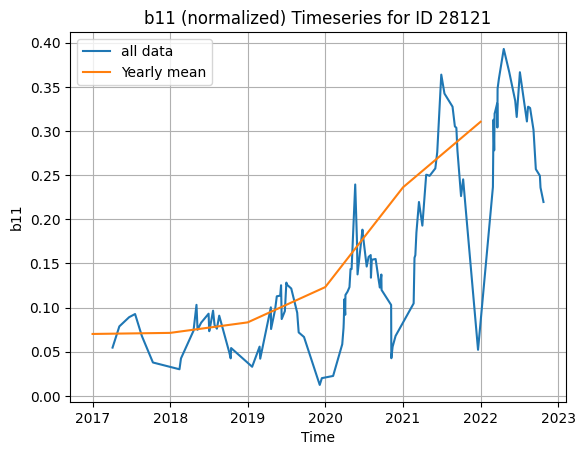

In [223]:
id = 28121
df_sub = df_norm[df_norm["id"] == id]

df_yearly_sub = df_yearly[df_yearly["id"] == id].copy()
df_yearly_sub["year_dt"] = pd.to_datetime(df_yearly_sub["year"].astype(str) + "-01-01")

plt.plot(df_sub["time"], df_sub[col], label="all data")
plt.plot(df_yearly_sub["year_dt"], df_yearly_sub[col], label="Yearly mean")

plt.title(f"{col} (normalized) Timeseries for ID {id}")
plt.xlabel("Time")
plt.ylabel(col)
plt.legend()
plt.grid(True)
plt.show()